In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Load the data
df1 = pd.read_csv("/content/sparsh1.csv")
df2 = pd.read_csv("/content/sparsh2.csv")
df3 = pd.read_csv("/content/sparsh3.csv")

# Define start and end markers
start_markers = ["start zero.png", "start one.png", "start two.jpg", "start three.jpg", "start four.jpg", "start five.jpg", "start six.jpg", "start seven.jpg", "start eight.jpg", "start nine.jpg", "start six.jpg"]
end_markers = ["end zero.png", "end one.png", "end two.jpg", "end three.jpg", "end four.jpg", "end five.jpg", "end six.jpg", "end seven.jpg", "end eight.jpg", "end nine.jpg"]

s = np.zeros((3, 10))
e = np.zeros((3, 10))

for j in range(len(end_markers)):
    for i in range(21525):
        if df1["435764"].iloc[i] == start_markers[j]:
            s[0][j] = i
            continue
        if df1["435764"].iloc[i] == end_markers[j]:
            e[0][j] = i
            break
    for i in range(21397):
        if df2["101749"].iloc[i] == start_markers[j]:
            s[1][j] = i
            continue
        if df2["101749"].iloc[i] == end_markers[j]:
            e[1][j] = i
            break
    for i in range(22165):
        if df3["252989"].iloc[i] == start_markers[j]:
            s[2][j] = i
            continue
        if df3["252989"].iloc[i] == end_markers[j]:
            e[2][j] = i
            break

signals = []
for i in range(10):
    signal0 = df1["435764"].iloc[int(s[0][i]+1):int(e[0][i])].to_numpy().astype(int)
    signal1 = df2["101749"].iloc[int(s[1][i]+1):int(e[1][i])].to_numpy().astype(int)
    signal2 = df3["252989"].iloc[int(s[2][i]+1):int(e[2][i])].to_numpy().astype(int)
    signals.append(signal0)
    signals.append(signal1)
    signals.append(signal2)




In [4]:
# Apply time slicing data augmentation
def augment_signal(signal, slice_range=5):
    augmented_signals = []
    for i in range(-slice_range, slice_range+1):
        augmented_signals.append(signal[max(0, i):min(len(signal), len(signal)+i)])
    return augmented_signals

augmented_signals = []
for signal in signals:
    augmented_signals.extend(augment_signal(signal))

max_len = 100
X = pad_sequences(augmented_signals, maxlen=max_len, padding='post')

# Update labels
y = np.array([1 if i % 2 == 0 else 0 for i in range(len(X))])


In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(100, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 98, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                100416    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/10
8/8 [==============================] - 1s 41ms/step - loss: 0.7209 - accuracy: 0.5022 - val_loss: 0.7015 - val_accuracy: 0.3469
Epoch 2/10
8/8 [==============================] - 0s 11ms/step - loss: 0.7045 - accuracy: 0.4892 - val_loss: 0.6981 - val_accuracy: 0.3469
Epoch 3/10
8/8 [==============================] - 0s 12ms/step - loss: 0.7072 - accuracy: 0.5498 - val_loss: 0.7026 - val_accuracy: 0.5102
Epoch 4/10
8/8 [==============================] - 0s 22ms/step - loss: 0.7024 - accuracy: 0.4978 - val_loss: 0.7155 - val_accuracy: 0.4286
Epoch 5/10
8/8 [==============================] - 0s 22ms/step - loss: 0.7334 - accuracy: 0.4978 - val_loss: 0.7339 - val_accuracy: 0.3469
Epoch 6/10
8/8 [==============================] - 0s 20ms/step - loss: 0.7051 - accuracy: 0.5541 - val_loss: 0.7037 - val_accuracy: 0.4286
Epoch 7/10
8/8 [==============================] - 0s 21ms/step - loss: 0.6925 - accuracy: 0.5152 - val_loss: 0.7060 - val_accuracy: 0.4286
Epoch 8/10
8/8 [===========

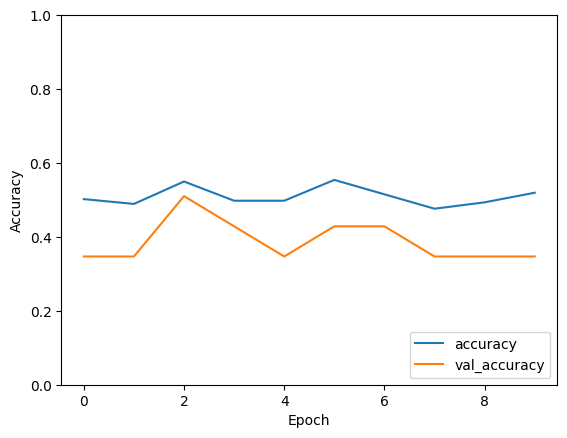

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

2/2 [==============================] - 0s 6ms/step


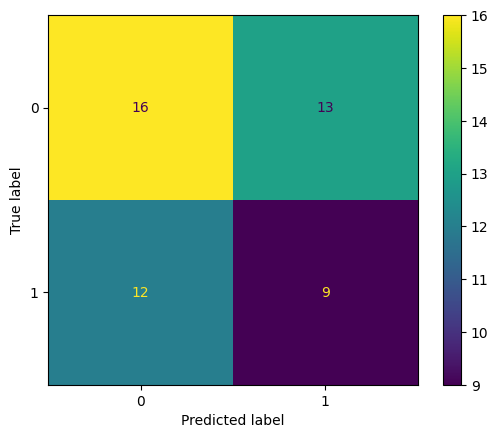

In [8]:

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()